In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

from utils.functions import *

In [2]:
train_data   = CustomMawiDataset(year='2019', month='01', as_matrix=False)
test_data    = CustomMawiDataset(year='2019', month='01', as_matrix=False)

torch.Size([938330, 48])
torch.Size([938330])
torch.Size([938330, 48])
torch.Size([938330])


In [3]:
test_data[0]

(tensor([ 1., 74., 74.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 74.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.]),
 tensor(0))

In [13]:
torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)

test_loader = DataLoader(test_data, batch_size=5000, shuffle=False)

In [26]:
for i, (X, y) in enumerate(test_loader):
    print(X.numpy().shape)
    y_np = y.numpy()
    print(np.count_nonzero(y_np == 1))

(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
970
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
3060
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
3854
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
4232
(5000, 48)
1377
(5000, 48)
0
(5000, 48)
3225
(5000, 48)
5000
(5000, 48)
1564
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
4954
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
3528
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
0
(5000, 48)
3485
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
4502
(5000, 48)
0
(5000, 48)
0
(5000, 48)
457
(5000, 48)
5000
(5000, 48)
5000
(5000, 48)
4584
(5000, 48)
0
(5000, 48)
756
(5000, 48)
5000
(5000, 48)
3904
(5000, 48)
0
(5000, 48)
0
(5

In [6]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=48, out_sz=2, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [7]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=48, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

## Define loss function & optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
import time
start_time = time.time()

epochs = 3
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 85.29566193  accuracy:  51.650%
epoch:  0  batch:  400 [ 40000/60000]  loss: 177.84921265  accuracy:  53.483%
epoch:  0  batch:  600 [ 60000/60000]  loss: 547.72784424  accuracy:  55.185%
epoch:  0  batch:  800 [ 80000/60000]  loss: 122.79354858  accuracy:  55.657%
epoch:  0  batch: 1000 [100000/60000]  loss: 5.57355785  accuracy:  55.999%
epoch:  0  batch: 1200 [120000/60000]  loss: 35.77248383  accuracy:  56.839%
epoch:  0  batch: 1400 [140000/60000]  loss: 15.87997341  accuracy:  57.657%
epoch:  0  batch: 1600 [160000/60000]  loss: 37.67325592  accuracy:  58.956%
epoch:  0  batch: 1800 [180000/60000]  loss: 2.24359465  accuracy:  59.545%
epoch:  0  batch: 2000 [200000/60000]  loss: 4.90122843  accuracy:  60.423%
epoch:  0  batch: 2200 [220000/60000]  loss: 41.68755341  accuracy:  61.120%
epoch:  0  batch: 2400 [240000/60000]  loss: 26.38664055  accuracy:  61.667%
epoch:  0  batch: 2600 [260000/60000]  loss: 2.38094020  accuracy:  62.425%


epoch:  2  batch: 3400 [340000/60000]  loss: 0.55093783  accuracy:  67.460%
epoch:  2  batch: 3600 [360000/60000]  loss: 0.58512491  accuracy:  67.463%
epoch:  2  batch: 3800 [380000/60000]  loss: 0.61356372  accuracy:  67.455%
epoch:  2  batch: 4000 [400000/60000]  loss: 0.54848886  accuracy:  67.485%
epoch:  2  batch: 4200 [420000/60000]  loss: 0.60005939  accuracy:  67.476%
epoch:  2  batch: 4400 [440000/60000]  loss: 0.58648044  accuracy:  67.486%
epoch:  2  batch: 4600 [460000/60000]  loss: 0.58387858  accuracy:  67.497%
epoch:  2  batch: 4800 [480000/60000]  loss: 0.52861035  accuracy:  67.477%
epoch:  2  batch: 5000 [500000/60000]  loss: 0.49742809  accuracy:  67.467%
epoch:  2  batch: 5200 [520000/60000]  loss: 0.51303983  accuracy:  67.475%
epoch:  2  batch: 5400 [540000/60000]  loss: 0.51829743  accuracy:  67.476%
epoch:  2  batch: 5600 [560000/60000]  loss: 0.59066397  accuracy:  67.443%
epoch:  2  batch: 5800 [580000/60000]  loss: 0.54300660  accuracy:  67.438%
epoch:  2  b

## Plot the loss and accuracy comparisons

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

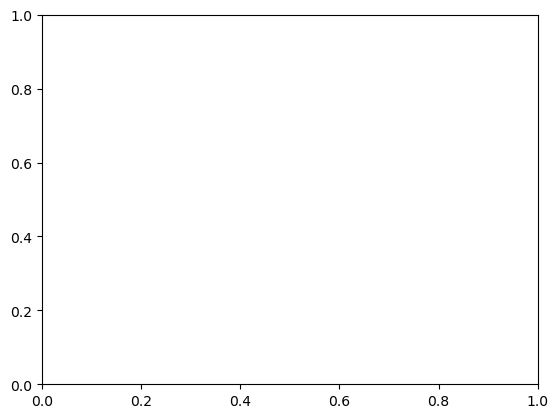

In [15]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

This shows some evidence of overfitting the training data.

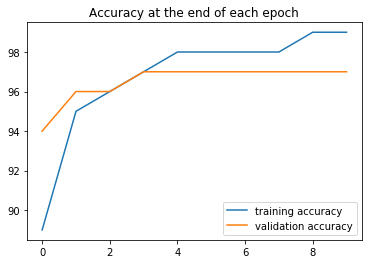

In [20]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data
We retained the test scores during our training session:

In [21]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9439), tensor(9635), tensor(9666), tensor(9726), tensor(9746), tensor(9758), tensor(9737), tensor(9749), tensor(9746), tensor(9725)]

Test accuracy: 97.250%


However, we'd like to compare the predicted values to the ground truth (the y_test labels), so we'll run the test set through the trained model all at once.

In [22]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [23]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9725/10000 =  97.250%


Not bad considering that a random guess gives only 10% accuracy!

## Display the confusion matrix
This uses scikit-learn, and the predicted values obtained above.

In [24]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 968    0    1    0    1    2    5    0    4    1]
 [   0 1126    4    0    0    0    2    5    0    4]
 [   2    1 1007    4    3    0    0   10    5    0]
 [   1    0    5  985    0    2    1    3    4    7]
 [   1    0    1    0  962    1    3    1    3   12]
 [   2    1    1   13    0  882   33    1   23   16]
 [   1    2    2    0    5    1  913    0    1    0]
 [   1    1    5    5    3    2    0 1003    7    7]
 [   2    4    6    2    1    2    1    1  925    8]
 [   2    0    0    1    7    0    0    4    2  954]]


This shows that the model had the greatest success with ones, twos and sevens, and the lowest with fives, sixes and eights.

## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [25]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

275

In [26]:
# Display the first 10 index positions
misses[:10]

array([  61,   62,   81,  104,  115,  151,  193,  217,  247,  259],
      dtype=int64)

In [27]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Now that everything is set up, run and re-run the cell below to view all of the missed predictions.<br>
Use <kbd>Ctrl+Enter</kbd> to remain on the cell between runs. You'll see a <tt>StopIteration</tt> once all the misses have been seen.

Index: [  61   62   81  104  115  151  193  217  247  259  264  320]
Label: [   8    9    6    9    4    9    9    6    4    6    9    9]
Guess: [   2    5    5    5    9    8    8    5    6    0    4    8]


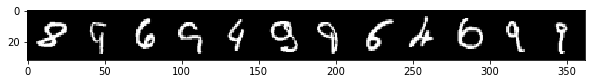

In [28]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Great job!